In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline
from sklearn.model_selection import train_test_split
from datetime import datetime
from tqdm import tqdm

In [2]:
# TODO's
##check batch norm
## maybe add regulariazation for every layer

In [3]:
tf.__version__

'1.4.0'

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

In [5]:
mnist = input_data.read_data_sets('D:/programming/python/datasets/mnist_data', one_hot=True)

Extracting D:/programming/python/datasets/mnist_data\train-images-idx3-ubyte.gz
Extracting D:/programming/python/datasets/mnist_data\train-labels-idx1-ubyte.gz
Extracting D:/programming/python/datasets/mnist_data\t10k-images-idx3-ubyte.gz
Extracting D:/programming/python/datasets/mnist_data\t10k-labels-idx1-ubyte.gz


[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


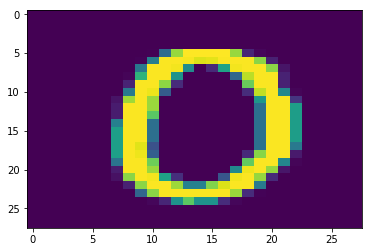

In [6]:
plt.imshow(mnist.train.images[10].reshape((28,28)),aspect='auto')
print(mnist.train.labels[10])

In [7]:
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

In [20]:
class DNN():
    def __init__(self,X,y,layers):
            self.X = X
            self.y = y
            self.layers = layers
            self.activations = [self.X]
            
    def forward(self):       
        for i,layer in enumerate(self.layers):
            layer.set_input(self.activations[i])
            self.activations.append(layer.forward())
        return self.activations
    
    def cost(self):
        #return tf.reduce_sum(tf.square(self.activations[-1]-self.y))
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.activations[-1],labels=self.y))
    
class DenseLayer():
    
    number = 0
    
    def __init__(self,units,activation_function=tf.nn.relu,batch_norm=False,keep_prob=1.0):
        self.units = units
        self.keep_prob = keep_prob
        self.activation_function = activation_function
        self.batch_norm = batch_norm
        self.variable_scope_name = 'Dense-'+str(DenseLayer.number)
        DenseLayer.number+=1
        
    def set_input(self,x):
        with tf.variable_scope(self.variable_scope_name):         
            self.x = x
            if(len(x.shape)==4):
                shape = self.x.get_shape().as_list()        
                dim = np.prod(shape[1:])
                self.x = tf.reshape(tensor=self.x,shape=[-1,dim])
            self.init_W((self.x.get_shape().as_list()[1],self.units))
            self.init_b(self.units)
            if(self.batch_norm):
                self.epsilon = 1e-3
                self.scale = tf.get_variable('scale', initializer=tf.ones(shape=[self.units]))
                self.beta =  tf.get_variable('beta', initializer=tf.zeros(shape=[self.units]))
        
    def init_W(self,shape):
        #another way to do this with get variable
        #self.w= tf.Variable(tf.multiply(tf.random_normal(shape),0.01),dtype=tf.float32)
        self.w=tf.get_variable('weight',shape=shape,initializer=tf.contrib.layers.xavier_initializer())
        tf.summary.histogram('weight',self.w)
    
    def init_b(self,shape):
        #self.b = tf.Variable(tf.fill([shape],0.1),dtype=tf.float32)
        init = tf.constant(0.1,shape=[shape])
        self.b = tf.get_variable('bias', initializer=init)
        tf.summary.histogram('bias',self.b)
        
    def forward(self):
        if self.x == None:
            print('no input defined')
        else:
            #batch norm not working properly
            #or maybe it is working properly but it needs bigger batch size. like 64. This makes sense because you make estimates of
            #mean and variance for every z calculation. This means that the bigger the batch size the more accurate the estimate
            if(self.batch_norm):
                self.z = tf.matmul(self.x,self.w)
                self.batch_mean, self.batch_var = tf.nn.moments(self.z,[0])
                self.z  = tf.nn.batch_normalization(self.z,self.batch_mean,self.batch_var,self.beta,self.scale,self.epsilon)
            else:
                self.z = tf.nn.xw_plus_b(self.x,self.w,self.b)
            if self.activation_function == None:
                self.activation = self.z
            else:
                self.activation  = self.activation_function(self.z)
            self.activation = tf.nn.dropout(self.activation,self.keep_prob)
            tf.summary.histogram('activations',self.activation)
            return self.activation
        
class ConvLayer():

    number = 0
    def __init__(self,kernel_size,number_of_kernels,padding='SAME',activation_function=tf.nn.relu,batch_norm = False,keep_prob=1.0):
        self.kernel_size = kernel_size
        self.number_of_kernels = number_of_kernels
        self.padding = padding
        self.activation_function = activation_function
        self.keep_prob = keep_prob
        self.batch_norm = batch_norm
        self.variable_scope_name = 'Conv-'+str(ConvLayer.number)
        ConvLayer.number+=1
        
    def set_input(self,x):
        with tf.variable_scope(self.variable_scope_name):         
            self.x = x
            if(isinstance(self.kernel_size,tuple)):
                self.init_Kernel(self.kernel_size+(x.get_shape().as_list()[-1],self.number_of_kernels))
            else:
                self.init_Kernel((self.kernel_size,self.kernel_size,x.get_shape().as_list()[-1],self.number_of_kernels)) 
            self.init_b(self.number_of_kernels)
            if(self.batch_norm):
                self.epsilon = 1e-3
                self.scale = tf.get_variable('scale', initializer=tf.ones(shape=[self.number_of_kernels]))
                self.beta =  tf.get_variable('beta', initializer=tf.zeros(shape=[self.number_of_kernels]))
        
    def init_Kernel(self,shape):
        self.kernel=tf.get_variable('kernel',shape=shape,initializer=tf.contrib.layers.xavier_initializer())
        tf.summary.histogram('kernel',self.kernel)
        
    def init_b(self,shape):
        self.b = tf.get_variable('bias',shape=[shape],initializer=tf.constant_initializer(0.1))
        tf.summary.histogram('bias',self.b)
        
    def forward(self):
        if self.x == None:
            print('no input defined')
        else:
            if self.batch_norm:
                
                self.z = tf.nn.conv2d(self.x , self.kernel, [1, 1, 1, 1], padding=self.padding)
                self.batch_mean, self.batch_var = tf.nn.moments(self.z,[0,1,2])
                self.z  = tf.nn.batch_normalization(self.z,self.batch_mean,self.batch_var,self.beta,self.scale,self.epsilon)
                
            else:
                self.z = tf.nn.conv2d(self.x , self.kernel, [1, 1, 1, 1], padding=self.padding)
                self.z = tf.nn.bias_add(self.z, self.b)  
                    
            if self.activation_function == None:
                self.activation = self.z
            else:
                self.activation  = self.activation_function(self.z)
            #dropout
            self.activation = tf.nn.dropout(self.activation,self.keep_prob)
            tf.summary.histogram('activations',self.activation)
        return self.activation
        
class PoolingLayer():
    
    number = 0
    
    def __init__(self,kernel_size,stride,padding='SAME',pooling='MAX'):
        self.kernel_size = kernel_size
        self.stride = stride
        self.pooling = pooling
        self.padding = padding
        self.variable_scope_name = 'Pool-'+str(PoolingLayer.number)
        PoolingLayer.number+=1
        
    def set_input(self,x):
        with tf.variable_scope(self.variable_scope_name):         
            self.x = x
        
    def forward(self):
        if self.x == None:
            print('no input defined')
        else:
            if(isinstance(self.kernel_size,tuple)):
                size = list(self.kernel_size)
            else:
                size = [self.kernel_size,self.kernel_size]   
            if (self.pooling == 'MAX'):
                self.activation = tf.nn.max_pool(self.x,[1]+size+[1],[1,self.stride,self.stride,1],padding=self.padding)
            elif (self.pooling == 'AVG'):
                self.activation = tf.nn.avg_pool(self.x,[1]+size+[1],[1,self.stride,self.stride,1],padding=self.padding)
        return self.activation
    
class EmbeddingLayer():
    
    number = 0
    
    def __init__(self,vocabulary_size,embedding_diamension,pretrained_word2vec=True,as_sequences=None):
        self.embedding_diamension = embedding_diamension
        self.vocabulary_size = vocabulary_size
        self.pretrained_word2vec = pretrained_word2vec
        self.variable_scope_name = 'Embedding-'+str(PoolingLayer.number)
        self.init_Embeddings((self.vocabulary_size,self.embedding_diamension))
        self.as_sequences = as_sequences
        EmbeddingLayer.number+=1
        
    def set_input(self,x):
        with tf.variable_scope(self.variable_scope_name):         
            self.x = x
            if self.as_sequences:
                self.sequence_length = x.shape[1]
        
    def init_Embeddings(self,shape):
        with tf.variable_scope(self.variable_scope_name):  
            if(self.pretrained_word2vec):             
                self.W = tf.Variable(tf.constant(0.0, shape=[self.vocabulary_size, self.embedding_diamension]),trainable=True, name="embedding_weights")
                self.embedding_placeholder = tf.placeholder(tf.float32, [self.vocabulary_size, self.embedding_diamension])
                self.embedding_init = self.W.assign(self.embedding_placeholder)
            else:
                self.W = tf.get_variable("embedding_weights", shape=[self.vocabulary_size, self.embedding_diamension],initializer=tf.contrib.layers.xavier_initializer())
    def forward(self):
        # TODO: implement as sequences to provide data for lstm
        if self.x == None:
            print('no input defined')
        else:
            #this is called activation to follow the pattern of other layers
            self.activation = tf.nn.embedding_lookup(self.W, self.x)
            if self.as_sequences == 'static':
                self.activation = tf.transpose(self.activation, [1,0,2])
                self.activation = tf.reshape(self.activation , [-1,self.embedding_diamension])
                self.activation  = tf.split(self.activation ,self.sequence_length,0)
            elif self.as_sequences == 'dynamic':
                pass
            else:
                self.activation = tf.expand_dims(self.activation, -1)        #need 4 diamensions to apply convolution
            return self.activation
class RnnLayer():
    number = 0
    def __init__(self,units,activation_function = None,cell_type = 'LSTM',keep_prob=1.0,rnn_type='static'):
        self.units = units
        self.activation_function = activation_function
        self.keep_prob = keep_prob
        self.cell_type = cell_type
        self.rnn_type = rnn_type
        self.variable_scope_name = 'Rnn-'+str(RnnLayer.number)
        RnnLayer.number+=1
        
    def set_input(self,x):
        with tf.variable_scope(self.variable_scope_name):         
            self.x = x
        
    def forward(self):
        if self.x == None:
            print('no input defined')
        else:
            if self.cell_type == 'LSTM':
                cell = tf.nn.rnn_cell.LSTMCell(self.units,activation=self.activation_function)
                cell = tf.nn.rnn_cell.DropoutWrapper(cell=cell, output_keep_prob=self.keep_prob)
            elif self.cell_type == 'GRU':
                cell = tf.nn.rnn_cell.GRUCell(self.units,activation=self.activation_function)
                cell = tf.nn.rnn_cell.DropoutWrapper(cell=cell, output_keep_prob=self.keep_prob)
                
            #need to fix this
            #self.activation = tf.nn.dynamic_rnn(cell,self.x,sequence_length=self.sequence_length)
            if (self.rnn_type == 'static'):
                self.output, self.states = tf.nn.static_rnn(cell,self.x,dtype=tf.float32)
                self.activation = self.output[-1]
            elif (self.rnn_type == 'dynamic'):
                self.output, self.states = tf.nn.dynamic_rnn(cell,self.x,dtype=tf.float32)
                self.activation = self.output[:,-1,:]
        return self.activation
    

In [28]:
##mnist with rnn
#inputs for DenseLayers
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

#inputs for rnn nets
X_train = X_train.reshape((X_train.shape[0],28,28))
y_train = y_train
X_test = X_test.reshape((X_test.shape[0],28,28))
y_test = y_test

#text classification with rnn
tf.reset_default_graph()
DenseLayer.number = 0
ConvLayer.number = 0
PoolingLayer.number = 0
EmbeddingLayer.number = 0
RnnLayer.number = 0

X = tf.placeholder(dtype=tf.float32,shape=(None,)+X_train.shape[1:])
y = tf.placeholder(dtype=tf.float32,shape=(None,)+y_train.shape[1:])

#for static rnn use this. for dynamic input have to be in the shape of (n*f)
# X = tf.transpose(X, [1,0,2])
# X = tf.reshape(X , [-1,28])
# X = tf.split(X,28,0)

epochs = 20
batch_size = 64

#dnn = DNN(X,y,[RnnLayer(64,activation_function=tf.nn.relu,rnn_type='dynamic'),DenseLayer(10,activation_function=None)])

dnn = DNN(X,y,[RnnLayer(64,activation_function=tf.nn.relu,rnn_type='dynamic',cell_type='LSTM'),DenseLayer(10,activation_function=None)])
output= dnn.forward()[-1]# last activation of th

loss = dnn.cost()
tf.summary.scalar('loss', loss)
optimizer = tf.train.AdamOptimizer()
train = optimizer.minimize(loss)

correct_pred = tf.equal(tf.argmax(output, 1), tf.argmax(dnn.y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
tf.summary.scalar('accuracy', accuracy)

#index of those that cant recognize
wrong_pred = tf.not_equal(tf.argmax(output, 1), tf.argmax(dnn.y, 1))
index = tf.where(wrong_pred)

# Merge all the summaries and write them out to /tmp/mnist_logs (by default)
merged = tf.summary.merge_all()

#to save model
saver = tf.train.Saver()

with tf.Session() as sess:
    #initialize variables
    sess.run(tf.global_variables_initializer())
    
    #write training data to file in order to visualize it with tensorboard
    log_name = datetime.now().strftime("%Y%m%d-%H%M%S")
    train_writer = tf.summary.FileWriter('summaries/train/logs'+log_name,sess.graph)
    test_writer = tf.summary.FileWriter('summaries/test/logs'+log_name,sess.graph)
    
      #this is computation heavy in large nets (memory inefficient)
#     #no training in this step, just inspecting the train cost and accuracy, also checking activations
#     feed_dict={dnn.X : X_train,dnn.y : y_train}
#     activations,last_activation,train_cost,train_acc= sess.run([activations,last_activation,loss,accuracy],feed_dict=feed_dict)
#     print("initial train cost "+str(train_cost))
#     print("initial train accuracy "+str(train_acc))
    
#     #no training in this step, just inspecting the test cost and accuracy
#     feed_dict={dnn.X : X_test,dnn.y : y_test}
#     test_cost,test_acc= sess.run([loss,accuracy],feed_dict=feed_dict)
#     print("initial test cost "+str(test_cost))
#     print("initial test accuracy "+str(test_acc))
    
    #training 
    for i in tqdm(range(epochs)):
        #mini batch training with my super generator function
        for c,batch in enumerate(range(int(np.ceil(mnist.train.num_examples/batch_size)))):
            batch = mnist.train.next_batch(batch_size=batch_size)
            batch_x = batch[0].reshape((batch[0].shape[0],28,28))
            batch_y = batch[1]                            
            feed_dict={dnn.X : batch_x,dnn.y : batch_y}
            cost,_,acc= sess.run([loss,train,accuracy],feed_dict=feed_dict)
            #print("cost in "+str(c)+' batch : '+str(cost))
            #print("accuracy in "+str(c)+' batch : '+str(acc))
            
  
        #for every epoch compute the accuracy and  loss but print it every n epochs
        
        #memory inefficient
        #train logging for every epoch
#         feed_dict={dnn.X : X_train,dnn.y : y_train}
#         summary,train_acc,train_cost = sess.run([merged,accuracy,loss],feed_dict=feed_dict)
#         train_writer.add_summary(summary, i)
        
        #test loggingfor every epoch
        feed_dict={dnn.X:X_test, dnn.y:y_test}
        summary,test_acc,test_cost = sess.run([merged,accuracy,loss],feed_dict=feed_dict)
        test_writer.add_summary(summary, i)
        
        if i%20==0:
            print('epoch:'+str(i))
            #print("cost after "+str(i)+' epoch : '+str(train_cost))
            #print("accuracy after "+str(i)+' epoch : '+str(train_acc))
           
    #save model (can save it if its better that the previous one etc)
    saver.save(sess,'models/mymodel.ckpt')
        
    feed_dict={dnn.X : X_test,dnn.y : y_test}
    wrong_pred_index,cost,test_acc = sess.run([index,loss,accuracy],feed_dict=feed_dict)
    print("test accuracy "+str(test_acc))

  0%|                                                                                          | 0/20 [00:00<?, ?it/s]


TypeError: unhashable type: 'list'

In [12]:
#inputs for DenseLayers
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

#inputs for conv nets
X_train = X_train.reshape((X_train.shape[0],28,28,1))
y_train = y_train
X_test = X_test.reshape((X_test.shape[0],28,28,1))
y_test = y_test

DenseLayer.number = 0
ConvLayer.number = 0
PoolingLayer.number = 0
tf.reset_default_graph()

epochs = 20
batch_size = 64
#dnn = DNN(X_train,y_train,[DenseLayer(64,batch_norm=True),DenseLayer(32,batch_norm=True),DenseLayer(10,activation_function=None,batch_norm=True)])
dnn = DNN(X_train,y_train,[ConvLayer(5,16,batch_norm=True),PoolingLayer(2,2),ConvLayer(5,32,batch_norm=True),PoolingLayer(2,2),\
                           DenseLayer(100,batch_norm=True),DenseLayer(50,batch_norm=True),\
                           DenseLayer(10,activation_function=None,batch_norm=True)])

activations = dnn.forward()
last_activation = activations[-1]

#save last layer activations as images
temp = tf.expand_dims(tf.expand_dims(last_activation,0),3)
tf.summary.image("images",temp)

loss = dnn.cost()
tf.summary.scalar('loss', loss)
optimizer = tf.train.AdamOptimizer()
train = optimizer.minimize(loss)

#multiple optimizers implementatio
# var_list1 = [variables from first 5 layers]
# var_list2 = [the rest of variables]
# opt1 = tf.train.GradientDescentOptimizer(0.00001)
# opt2 = tf.train.GradientDescentOptimizer(0.0001)
# grads = tf.gradients(loss, var_list1 + var_list2)
# grads1 = grads[:len(var_list1)]
# grads2 = grads[len(var_list1):]
# tran_op1 = opt1.apply_gradients(zip(grads1, var_list1))
# train_op2 = opt2.apply_gradients(zip(grads2, var_list2))
# train_op = tf.group(train_op1, train_op2)

correct_pred = tf.equal(tf.argmax(activations[-1], 1), tf.argmax(dnn.y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
tf.summary.scalar('accuracy', accuracy)

#index of those that cant recognize
wrong_pred = tf.not_equal(tf.argmax(activations[-1], 1), tf.argmax(dnn.y, 1))
index = tf.where(wrong_pred)

# Merge all the summaries and write them out to /tmp/mnist_logs (by default)
merged = tf.summary.merge_all()

#to save model
saver = tf.train.Saver()

with tf.Session() as sess:
    #initialize variables
    sess.run(tf.global_variables_initializer())
    
    #write training data to file in order to visualize it with tensorboard
    log_name = datetime.now().strftime("%Y%m%d-%H%M%S")
    train_writer = tf.summary.FileWriter('summaries/train/logs'+log_name,sess.graph)
    test_writer = tf.summary.FileWriter('summaries/test/logs'+log_name,sess.graph)
    
      #this is computation heavy in large nets (memory inefficient)
#     #no training in this step, just inspecting the train cost and accuracy, also checking activations
#     feed_dict={dnn.X : X_train,dnn.y : y_train}
#     activations,last_activation,train_cost,train_acc= sess.run([activations,last_activation,loss,accuracy],feed_dict=feed_dict)
#     print("initial train cost "+str(train_cost))
#     print("initial train accuracy "+str(train_acc))
    
#     #no training in this step, just inspecting the test cost and accuracy
#     feed_dict={dnn.X : X_test,dnn.y : y_test}
#     test_cost,test_acc= sess.run([loss,accuracy],feed_dict=feed_dict)
#     print("initial test cost "+str(test_cost))
#     print("initial test accuracy "+str(test_acc))
    
    #training 
    for i in tqdm(range(epochs)):
        #mini batch training with my super generator function
        for c,batch in enumerate(range(int(np.ceil(mnist.train.num_examples/batch_size)))):
            batch = mnist.train.next_batch(batch_size=batch_size)
            batch_x = batch[0].reshape((batch[0].shape[0],28,28,1))
            batch_y = batch[1]                            
            feed_dict={dnn.X : batch_x,dnn.y : batch_y}
            cost,_,acc= sess.run([loss,train,accuracy],feed_dict=feed_dict)
            #print("cost in "+str(c)+' batch : '+str(cost))
            #print("accuracy in "+str(c)+' batch : '+str(acc))
            
  
        #for every epoch compute the accuracy and  loss but print it every n epochs
        
        #memory inefficient
        #train logging for every epoch
#         feed_dict={dnn.X : X_train,dnn.y : y_train}
#         summary,train_acc,train_cost = sess.run([merged,accuracy,loss],feed_dict=feed_dict)
#         train_writer.add_summary(summary, i)
        
        #test loggingfor every epoch
        feed_dict={dnn.X:X_test, dnn.y:y_test}
        summary,test_acc,test_cost = sess.run([merged,accuracy,loss],feed_dict=feed_dict)
        test_writer.add_summary(summary, i)
        
        if i%20==0:
            print('epoch:'+str(i))
            #print("cost after "+str(i)+' epoch : '+str(train_cost))
            #print("accuracy after "+str(i)+' epoch : '+str(train_acc))
           
    #save model (can save it if its better that the previous one etc)
    saver.save(sess,'models/mymodel.ckpt')
        
    feed_dict={dnn.X : X_test,dnn.y : y_test}
    wrong_pred_index,cost,test_acc = sess.run([index,loss,accuracy],feed_dict=feed_dict)
    print("test accuracy "+str(test_acc))

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

epoch:0


  5%|████▏                                                                              | 1/20 [00:33<10:37, 33.55s/it]

KeyboardInterrupt: 

In [ ]:
wrong = wrong_pred_index.squeeze()
print(wrong.shape)
f = plt.figure(figsize=(20,10))
for i,index in enumerate(wrong):
    f.add_subplot(7,10,i+1)
    plt.imshow(X_test[index].reshape((28,28)),aspect='auto')